In [ ]:
import tensorflow as tf
import numpy as np
import os
import IPython
import note_seq
from magenta.scripts.convert_dir_to_note_sequences import convert_directory
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel
import time

In [ ]:
# 즉시 실행 모드 활성화
# tf.compat.v1.enable_eager_execution()
# 즉시 실행 모드 비활성화
# tf.compat.v1.disable_eager_execution()

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

### 데이터 전처리 (preprocessing)
Groove MIDI 데이터셋(c.f.드럼)을 불러와, 벡터로 변환하여 tfrecord 형식으로 저장한다.

In [ ]:
# 구글 드라이브로부터 Groove 데이터셋을 불러온다.
input_path = "/content/drive/MyDrive/musicVAE/groove"
# 데이터를 tfrecord로 변환하여 저장할 파일의 경로를 지정
output_file_path = "/content/drive/MyDrive/musicVAE/groove_output.tfrecord"

In [ ]:
# magenta 라이브러리를 이용하여, 데이터를 tfrecord 형태로 변환
convert_directory(input_path, output_file_path, recursive=True)

In [ ]:
raw_dataset = tf.data.TFRecordDataset(output_file_path)
#raw_dataset
# 데이터 구경
# for raw_record in raw_dataset.take(10):
#   print(repr(raw_record))

### 학습 단계 (training)
전처리한 데이터를 이용하여, 4마디 드럼 악보 모델을 학습한다.

1. magenta 라이브러리 이용

In [ ]:
# from magenta.models.music_vae import music_vae_train

1의 방법이 실패하여, 
2. music_vae_train.py 코드 이용



```
사용 예시:
music_vae_train \
--config=cat-mel_2bar_small \
--run_dir=/tmp/music_vae/ \
--mode=train \
--examples_path=/tmp/music_vae/mel_train_examples.tfrecord

```



In [ ]:
"""MusicVAE training script."""
import os
from magenta.models.music_vae import configs
from magenta.models.music_vae import data
import tensorflow.compat.v1 as tf
import tf_slim

# Should not be called from within the graph to avoid redundant summaries.
def _trial_summary(hparams, examples_path, output_dir):
  """Writes a tensorboard text summary of the trial."""

  examples_path_summary = tf.summary.text(
      'examples_path', tf.constant(examples_path, name='examples_path'),
      collections=[])

  hparams_dict = hparams.values()

  # Create a markdown table from hparams.
  header = '| Key | Value |\n| :--- | :--- |\n'
  keys = sorted(hparams_dict.keys())
  lines = ['| %s | %s |' % (key, str(hparams_dict[key])) for key in keys]
  hparams_table = header + '\n'.join(lines) + '\n'

  hparam_summary = tf.summary.text(
      'hparams', tf.constant(hparams_table, name='hparams'), collections=[])
  
  # eval() 오류시:  tensorflow as tf --> tensorflow.compat.v1 as tf 
  with tf.Session() as sess:
    writer = tf.summary.FileWriter(output_dir, graph=sess.graph)
    writer.add_summary(examples_path_summary.eval())
    writer.add_summary(hparam_summary.eval())
    writer.close()


def _get_input_tensors(dataset, config):
  """Get input tensors from dataset."""
  batch_size = config.hparams.batch_size #기본 설정된 배치 사이즈 유지
  iterator = tf.data.make_one_shot_iterator(dataset)
  (input_sequence, output_sequence, control_sequence,
   sequence_length) = iterator.get_next()
  input_sequence.set_shape(
      [batch_size, None, config.data_converter.input_depth])
  output_sequence.set_shape(
      [batch_size, None, config.data_converter.output_depth])
  if not config.data_converter.control_depth:
    control_sequence = None
  else:
    control_sequence.set_shape(
        [batch_size, None, config.data_converter.control_depth])
  sequence_length.set_shape([batch_size] + sequence_length.shape[1:].as_list())

  return {
      'input_sequence': input_sequence,
      'output_sequence': output_sequence,
      'control_sequence': control_sequence,
      'sequence_length': sequence_length
  }
'''
참고: 'groovae_4bar' config의 hparams

      hparams=merge_hparams(
        lstm_models.get_default_hparams(),
        HParams(
            batch_size=512,
            max_seq_len=16 * 4,  # 4 bars w/ 16 steps per bar
            z_size=256,
            enc_rnn_size=[512],
            dec_rnn_size=[256, 256],
            max_beta=0.2,
            free_bits=48,
            dropout_keep_prob=0.3,
        ))

'''


# 학습. args 원본 코드 참조.
def train(train_dir,
          config,
          dataset_fn,
          checkpoints_to_keep=5,
          keep_checkpoint_every_n_hours=1,
          num_steps=None,
          master='',
          num_sync_workers=0,
          num_ps_tasks=0,
          task=0):
  """Train loop."""
  tf.gfile.MakeDirs(train_dir)
  is_chief = (task == 0)
  if is_chief:
    _trial_summary(
        config.hparams, config.train_examples_path or config.tfds_name,
        train_dir)
  with tf.Graph().as_default():
    with tf.device(tf.train.replica_device_setter(
        num_ps_tasks, merge_devices=True)):

      model = config.model
      model.build(config.hparams,
                  config.data_converter.output_depth,
                  is_training=True)

      optimizer = model.train(**_get_input_tensors(dataset_fn(), config))

      hooks = []
      if num_sync_workers:
        optimizer = tf.train.SyncReplicasOptimizer(
            optimizer,
            num_sync_workers)
        hooks.append(optimizer.make_session_run_hook(is_chief))

      grads, var_list = list(zip(*optimizer.compute_gradients(model.loss)))
      global_norm = tf.global_norm(grads)
      tf.summary.scalar('global_norm', global_norm)

      if config.hparams.clip_mode == 'value':
        g = config.hparams.grad_clip
        clipped_grads = [tf.clip_by_value(grad, -g, g) for grad in grads]
      elif config.hparams.clip_mode == 'global_norm':
        clipped_grads = tf.cond(
            global_norm < config.hparams.grad_norm_clip_to_zero,
            lambda: tf.clip_by_global_norm(  # pylint:disable=g-long-lambda
                grads, config.hparams.grad_clip, use_norm=global_norm)[0],
            lambda: [tf.zeros(tf.shape(g)) for g in grads])
      else:
        raise ValueError(
            'Unknown clip_mode: {}'.format(config.hparams.clip_mode))
      train_op = optimizer.apply_gradients(
          list(zip(clipped_grads, var_list)),
          global_step=model.global_step,
          name='train_step')

      logging_dict = {'global_step': model.global_step,
                      'loss': model.loss}

      hooks.append(tf.train.LoggingTensorHook(logging_dict, every_n_iter=100))
      if num_steps:
        hooks.append(tf.train.StopAtStepHook(last_step=num_steps))

      scaffold = tf.train.Scaffold(
          saver=tf.train.Saver(
              max_to_keep=checkpoints_to_keep,
              keep_checkpoint_every_n_hours=keep_checkpoint_every_n_hours))
      tf_slim.training.train(
          train_op=train_op,
          logdir=train_dir,
          scaffold=scaffold,
          hooks=hooks,
          save_checkpoint_secs=60,
          master=master,
          is_chief=is_chief)


def run(config_map,
        tf_file_reader=tf.data.TFRecordDataset,
        file_reader=tf.python_io.tf_record_iterator,is_training = True):
  """Load model params, save config file and start trainer.
  Args:
    config_map: Dictionary mapping configuration name to Config object.
    tf_file_reader: The tf.data.Dataset class to use for reading files.
    file_reader: The Python reader to use for reading files.
  Raises:
    ValueError: if required flags are missing or invalid.
  """

  # 학습 결과를 저장할 디렉토리를 임의로 지정함
  train_dir = '/content/drive/MyDrive/musicVAE/train_vae'
  config = config_map['groovae_4bar'] # 4마디 옵션 선택

  # 데이터셋으로부터 입력 텐서를 가져온다.
  def dataset_fn():
        return data.get_dataset(
            config, # 데이터셋에 대한 정보를 담은 객체
            tf_file_reader=tf_file_reader, # 파일을 읽어오기 위한 tf.data.Dataset 클래스
            is_training=True,
            cache_dataset=True) # 불리언: 학습 데이터를 메모리에 캐시하여 속도를 향상시킬지 True/False.
      # 입력, 출력, 컨트롤, 길이 텐서를 포함하는 tf.data.Dataset 리턴
  
  if is_training == True:  
    train( # magenta 라이브러리상 원본 코드 참조하여 임의 설정.
        train_dir,
        config=config,
        dataset_fn=dataset_fn,
        checkpoints_to_keep=5,
        num_steps=20000
        # keep_checkpoint_every_n_hours=1,
    )

run(configs.CONFIG_MAP)

In [ ]:
# print(configs.CONFIG_MAP['groovae_4bar'])
#print(configs.CONFIG_MAP['groovae_4bar'].hparams.max_seq_len)

### 샘플 만들기
학습(train)시와 같은 이유로, music_vae_generate.py 코드를 직접 가져온다.

```
사용 예시:
music_vae_generate \
--config=cat-mel_2bar_big \
--checkpoint_file=/path/to/music_vae/checkpoints/cat-mel_2bar_big.tar \
--mode=sample \
--num_outputs=5 \
--output_dir=/tmp/music_vae/generated
```



In [ ]:
logging = tf.logging

def run(config_map):
  """Load model params, save config file and start trainer.
  Args:
    config_map: Dictionary mapping configuration name to Config object.
  """
  date_and_time = time.strftime('%Y-%m-%d_%H%M%S')
  num_outputs = 5 # 5, 임의로 깃헙 예시와 동일하게 설정함
  config = config_map['groovae_4bar']
  

  # 학습 및 저장된 모델 불러오기
  model = TrainedModel(
      config, 
      batch_size=min(1, num_outputs), # FLAGS 정보 대신 임의로 1 설정
      checkpoint_dir_or_path='/content/drive/MyDrive/musicVAE/train_vae')

  
  logging.info('Sampling...')

  # 샘플링
  results = model.sample(
      # n=FLAGS.num_outputs,
      # length=config.hparams.max_seq_len,
      # temperature=FLAGS.temperature)
      n = num_outputs,
      length= config.hparams.max_seq_len,
      temperature = 0.5)
  
  # 샘플 저장 경로들 지정
  output_dir='/content/drive/MyDrive/musicVAE/generated'
  mode="sample"
  basename = os.path.join(
      # FLAGS.output_dir,
      # '%s_%s_%s-*-of-%03d.mid' %
      # (FLAGS.config, FLAGS.mode, date_and_time, FLAGS.num_outputs))
      output_dir,
      '%s_%s_%s-*-of-%03d.mid' %
      ('groovae_4bar', mode, date_and_time, num_outputs)
  )
  logging.info('Outputting %d files as `%s`...', num_outputs, basename)
  for i, ns in enumerate(results):
    note_seq.sequence_proto_to_midi_file(ns, basename.replace('*', '%03d' % i))

  logging.info('Done.')

run(configs.CONFIG_MAP)

[첨부] 구글 드라이브에서 생성된 샘플 목록 확인

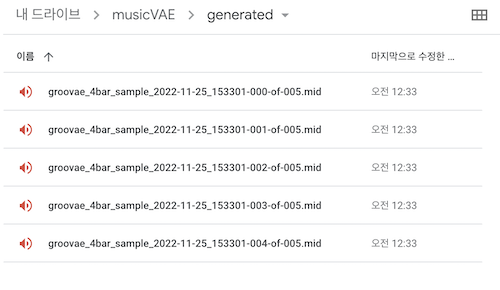